## Initial Orbit Analysis

Data and results files for this notebook may be downloaded [here](https://dirac.astro.washington.edu/~moeyensj/projects/thor/paper1/).

In [1]:
import glob
import os
import sys
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors

from matplotlib.ticker import AutoMinorLocator
from scipy.stats import binned_statistic_2d

import seaborn as sns

sns.set(font_scale=1.2, context="paper", style="ticks")
sns.set_palette("viridis")

%matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

sys.path.append("../../thor/")

In [2]:
import thor

../../thor/thor/orbits/kepler.py:57: NumbaPerformanceWarning:

np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))

../../thor/thor/orbits/kepler.py:79: NumbaPerformanceWarning:

np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))

../../thor/thor/orbits/kepler.py:80: NumbaPerformanceWarning:

np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))

../../thor/thor/orbits/propagate/universal.py:46: NumbaPerformanceWarning:

np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))



In [3]:
DPI = 300
SAVE_DIR = "plots/"
FORMAT = "png"

SAVE_FIGS = True

### Simulations

In [4]:
RUN_DIR = "/Users/moeyensj/Google Drive/Astronomy/Data/thor/results/msst_4x4/run_16/"
IOD_DIR = os.path.join(RUN_DIR, "iod_orbits")
DATABASE = "/Users/moeyensj/Google Drive/Astronomy/Data/thor/data/msst_4x4/msst_4x4/msst_survey.db"
con = sql.connect(DATABASE)

In [5]:
test_orbits_survey = pd.read_csv(os.path.join(RUN_DIR, "orbits.txt"), sep=" ", index_col=False)
allObjects_survey = pd.read_csv(os.path.join(RUN_DIR, "allObjects_survey.txt"), sep=" ", index_col=False)

known_orbits = pd.read_sql("SELECT * FROM mpcOrbitCat", con)
known_orbits = known_orbits[known_orbits["designation"].isin(allObjects_survey["designation"].values)]

In [6]:
findable = allObjects_survey[allObjects_survey["findable"] == 1]["designation"].values
found = allObjects_survey[allObjects_survey["found"] == 1]["designation"].values
missed = allObjects_survey[(allObjects_survey["found"] == 0) & (allObjects_survey["findable"] == 1) ]["designation"].values
test_orbits = test_orbits_survey["designation"].values

In [7]:
# Loop through the IOD orbits directory, read orbit file, crossmatch orbit with the clusterMembers DataFrame to calculate
# arc length 
DO_PROCESSING = False
if DO_PROCESSING:
    iod_orbits = []
    cluster_members = []
    for iod_file in os.listdir(IOD_DIR):
        orbits_df = pd.read_csv(os.path.join(IOD_DIR, iod_file),
                         sep=" ", 
                         index_col=False, 
                         low_memory=False,
                         header=0,
                         names=["orbit_id", "cluster_id", "epoch_mjd",
                                "obj_x", "obj_y", "obj_z", 
                                "obj_vx", "obj_vy", "obj_vz", 
                                "rchi2",  "linked_object",
                                "pure", "partial", "false"])


        orbit_id = iod_file.split("_")[2].split(".")[0]
        orbit_dir = os.path.join(RUN_DIR, "orbit_{}".format(orbit_id))

        allClusters = pd.read_csv(os.path.join(orbit_dir, "allClusters.txt"), sep=" ", index_col=False)
        clusterMembers = pd.read_csv(os.path.join(orbit_dir, "clusterMembers.txt"), sep=" ", index_col=False)
        projected_obs = pd.read_csv(os.path.join(orbit_dir, "projected_obs.txt"), sep=" ", index_col=False)

        orbits_df = orbits_df.merge(allClusters[["cluster_id", "num_obs"]], on="cluster_id")
        orbits_df["chi2"] = orbits_df["rchi2"] * (2 * orbits_df["num_obs"] - 6)

        merged = clusterMembers.merge(projected_obs[["obsId", "exp_mjd"]], on="obsId")
        merged.sort_values(by=["cluster_id", "exp_mjd"], inplace=True)
        merged.reset_index(inplace=True, drop=True)
        merged = pd.DataFrame(merged.groupby(by="cluster_id").apply(lambda x: x.exp_mjd.max() - x.exp_mjd.min()), columns=["arc"])
        merged.reset_index(inplace=True)
        
        clusterMembers = clusterMembers[clusterMembers["cluster_id"].isin(orbits_df["cluster_id"].unique())] 
        clusterMembers["orbit_id"] = [orbits_df["orbit_id"].values[0] for i in range(len(clusterMembers))]
        clusterMembers = clusterMembers[["orbit_id", "cluster_id", "obsId"]]

        orbits_df = orbits_df.merge(merged[["cluster_id", "arc"]], on="cluster_id")
        orbits_df = orbits_df[[
            'orbit_id', 'cluster_id', 'epoch_mjd',
            'obj_x', 'obj_y', 'obj_z',
            'obj_vx', 'obj_vy', 'obj_vz',  
            'pure', 'partial', 'false', 
            'linked_object', 'num_obs', 'rchi2', 
            'chi2', 'arc'
        ]]
        
        cluster_members.append(clusterMembers)
        iod_orbits.append(orbits_df)

    iod_orbits = pd.concat(iod_orbits, sort=False)
    iod_orbits.sort_values(by=["orbit_id", "cluster_id"], inplace=True)
    iod_orbits.reset_index(inplace=True, drop=True)
    
    clusterMembers = pd.concat(cluster_members, sort=False)
    clusterMembers.sort_values(by=["orbit_id", "cluster_id"], inplace=True)
    clusterMembers.reset_index(inplace=True, drop=True)
    
    iod_orbits.to_csv(os.path.join(RUN_DIR, "processed_iod_orbits.txt"), sep=" ", index=False)
    clusterMembers.to_csv(os.path.join(RUN_DIR, "processed_orbit_members.txt"), sep=" ", index=False)
    
else:
    iod_orbits = pd.read_csv(os.path.join(RUN_DIR, "processed_iod_orbits.txt"), sep=" ", index_col=False)
    clusterMembers = pd.read_csv(os.path.join(RUN_DIR, "processed_orbit_members.txt"), sep=" ", index_col=False)

In [8]:
iod_orbits.head()

,orbit_id,cluster_id,epoch_mjd,obj_x,obj_y,obj_z,obj_vx,obj_vy,obj_vz,pure,partial,false,linked_object,num_obs,rchi2,chi2,arc
0,1,1,59746.264011,-0.311034,-1.011664,-0.007969,0.015202,-0.002215,-0.001034,0,0,1,NaN,5,11938.618393,47754.473571,9.999306
1,1,2,59746.243946,-0.537039,-0.977568,0.028769,0.015287,-0.003066,-0.002160,0,0,1,NaN,5,6770.799193,27083.196774,4.000000
2,1,3,59748.238495,-1.687883,-0.959696,-0.056325,0.006100,-0.005994,-0.007421,0,0,1,NaN,5,10437.358027,41749.432107,10.000694
3,1,4,59746.227393,-2.056117,-0.690633,0.047988,0.002061,-0.007411,-0.008572,0,0,1,NaN,5,10442.897748,41771.590993,7.999306
4,1,5,59746.257470,-1.563348,-0.975480,0.018447,0.004274,-0.005700,-0.006861,0,0,1,NaN,5,9877.644157,39510.576630,9.999306


In [9]:
def printIODResults(iod_orbits, allObjects_survey, chi2_cut=500, falsePositiveIds=[], unknownIds=["-1", -1]):

    findable = allObjects_survey[allObjects_survey["findable"] == 1]["designation"].unique()
    found_clusters = allObjects_survey[allObjects_survey["found"] == 1]["designation"].unique()
    print("Number of known objects recovered in clusters: {:.2f}%".format(100 * (len(found_clusters)/len(findable))))
    
    # Create initial orbit masks based on known and unknown linkages
    known = (~iod_orbits["linked_object"].isin(falsePositiveIds + unknownIds))
    known_pure = known & (iod_orbits["pure"] == 1)
    known_partial = known & (iod_orbits["partial"] == 1)
    unknown = iod_orbits["linked_object"].isin(falsePositiveIds + unknownIds)

    num_cut = len(iod_orbits[iod_orbits["chi2"] <= chi2_cut])
    found_iod_num = len(iod_orbits[known & (iod_orbits["chi2"] <= chi2_cut)])
    found_iod = iod_orbits[known & (iod_orbits["chi2"] <= chi2_cut)]["linked_object"].unique()
    found_iod_pure_num = len(iod_orbits[known_pure & (iod_orbits["chi2"] <= chi2_cut)])
    found_iod_pure = iod_orbits[known_pure & (iod_orbits["chi2"] <= chi2_cut)]["linked_object"].unique()
    found_iod_partial_num = len(iod_orbits[known_partial & (iod_orbits["chi2"] <= chi2_cut)])
    found_iod_partial = iod_orbits[known_partial & (iod_orbits["chi2"] <= chi2_cut)]["linked_object"].unique()

    unknown_after_cut =  iod_orbits[unknown & (iod_orbits["chi2"] <= chi2_cut)]

    print("Total number of known objects findable: {}".format(len(findable)))
    print("Total number of known objects found in clusters: {}".format(len(found_clusters)))
    print("")

    print("Total number of orbits: {}".format(len(iod_orbits)))
    print("Number of orbits chi-squared <= {}: {}".format(chi2_cut, num_cut))
    print("\tNumber of orbits resulting from known pure clusters: {} ({:.2f}%)".format(found_iod_pure_num, 
                                                                                       100*found_iod_pure_num/num_cut))
    print("\tNumber of unique known objects in these orbits: {} ({:.2f}%)".format(len(found_iod_pure), 
                                                                                  100*len(found_iod_pure)/len(findable)))
    print("\tNumber of orbits resulting from known partial clusters: {} ({:.2f}%)".format(found_iod_partial_num, 
                                                                                          100*found_iod_partial_num/num_cut))
    print("\tNumber of unique known objects in these orbits: {} ({:.2f}%)".format(len(found_iod_partial),
                                                                                  100*len(found_iod_partial)/len(findable)))
    print("\tNumber of orbits resulting from unknown clusters: {} ({:.2f}%)".format(len(unknown_after_cut), 
                                                                                    100*len(unknown_after_cut)/num_cut))

    print("Percent of known objects recovered in high quality orbits: {} {:.2f}%".format(
           len(np.unique(np.concatenate([found_iod_partial.astype(str), found_iod_pure.astype(str)]))), 
           100 * (
           len(np.unique(np.concatenate([found_iod_partial.astype(str), found_iod_pure.astype(str)]))) / len(findable))))
    
    return known, known_pure, known_partial, unknown

In [10]:
known, known_pure, known_partial, unknown = printIODResults(iod_orbits, allObjects_survey, unknownIds=[], falsePositiveIds=["NS", np.NaN], chi2_cut=500)

Number of known objects recovered in clusters: 94.57%
Total number of known objects findable: 18332
Total number of known objects found in clusters: 17337

Total number of orbits: 229810
Number of orbits chi-squared <= 500: 46790
	Number of orbits resulting from known pure clusters: 46608 (99.61%)
	Number of unique known objects in these orbits: 16083 (87.73%)
	Number of orbits resulting from known partial clusters: 69 (0.15%)
	Number of unique known objects in these orbits: 27 (0.15%)
	Number of orbits resulting from unknown clusters: 113 (0.24%)
Percent of known objects recovered in high quality orbits: 16102 87.84%


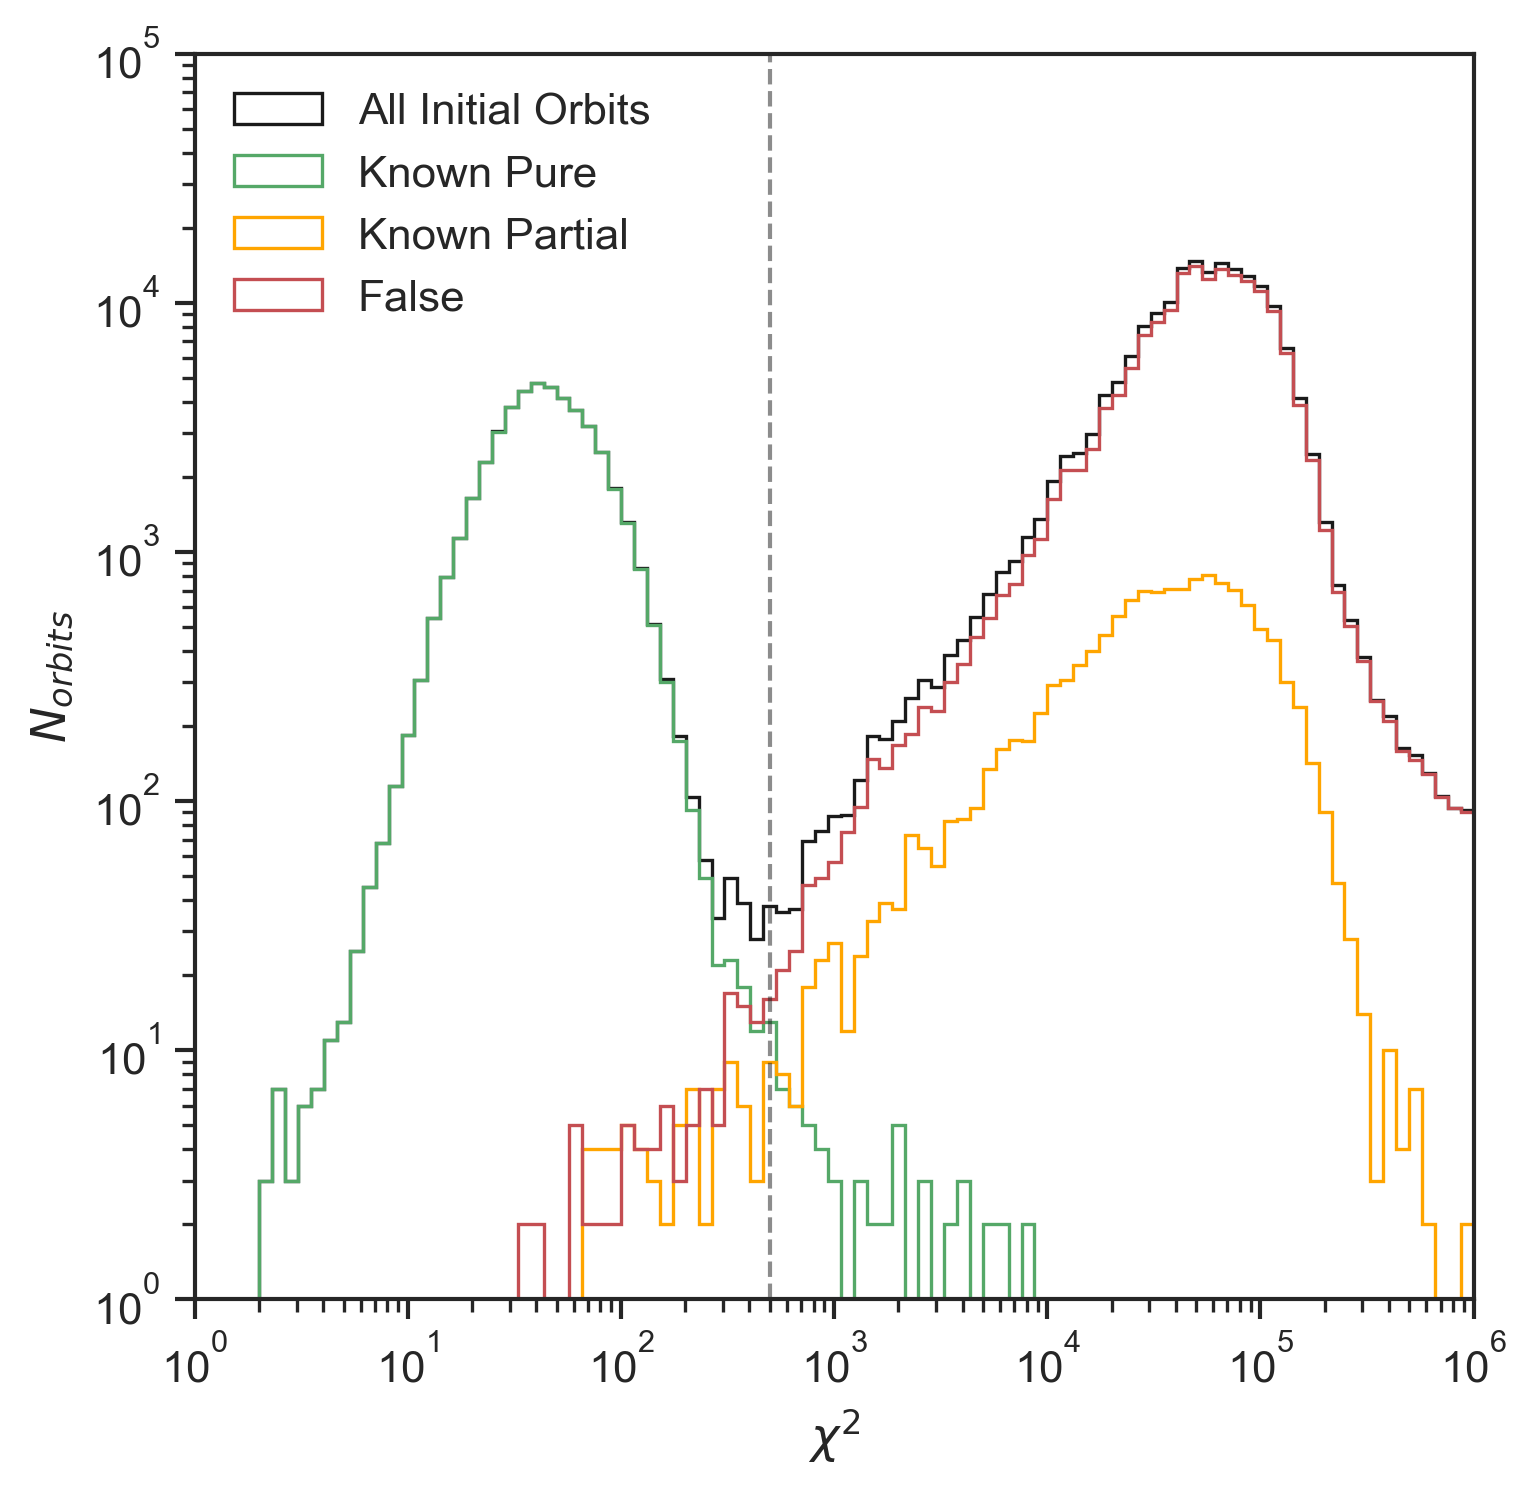

In [11]:
log_range = (0, 6)
bins = 100

fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5.5, 5.5))
stats = ax.hist(iod_orbits["chi2"].values, 
                   bins=np.logspace(*log_range, bins),
                   density=False, 
                   histtype="step", 
                   label="All Initial Orbits",
                   color="k")
stats_pu = ax.hist(iod_orbits[known_pure]["chi2"].values, 
                   bins=np.logspace(*log_range, bins),
                   density=False, 
                   histtype="step", 
                   label="Known Pure",
                   color="g")
stats_pa = ax.hist(iod_orbits[known_partial]["chi2"].values,
                   bins=np.logspace(*log_range, bins),  
                   density=False, 
                   histtype="step",
                   label="Known Partial",
                   color="orange")
stats_un = ax.hist(iod_orbits[unknown]["chi2"].values, 
                   bins=np.logspace(*log_range, bins), 
                   density=False, 
                   histtype="step", 
                   label="False",
                   color="r")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.set_xlim(10**log_range[0], 10**log_range[1])
ax.set_ylim(1, 10**5)
ax.vlines([500], 1, 10**5, lw=1, ls="--", alpha=0.5)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$N_{orbits}$")
ax.set_xlabel(r"$\chi^2$")
ax.legend(loc="upper left", frameon=False)

if SAVE_FIGS == True:
    fig.savefig(os.path.join(SAVE_DIR, "simulations_iod.{}".format(FORMAT)),
            bbox_inches='tight')

In [12]:
found_iod = iod_orbits[(iod_orbits["chi2"] <= 500) & known]["linked_object"].unique()

In [13]:
sma_bins = [1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0, 50.0]

for a_min, a_max in zip(sma_bins[:-1], sma_bins[1:]):
    found_in_bin = len(known_orbits[(known_orbits["a_au"] >= a_min) & (known_orbits["a_au"] < a_max) & known_orbits["designation"].isin(found_iod)]) 
    findable_in_bin = len(known_orbits[(known_orbits["a_au"] >= a_min) & (known_orbits["a_au"] < a_max) & known_orbits["designation"].isin(findable)])
    print("Completeness between {} and {} AU: {:.2f} %, {}".format(a_min, a_max, found_in_bin / findable_in_bin * 100.0, found_in_bin))

Completeness between 1.7 and 2.06 AU: 60.42 %, 116
Completeness between 2.06 and 2.5 AU: 82.21 %, 5708
Completeness between 2.5 and 2.82 AU: 92.00 %, 5903
Completeness between 2.82 and 2.95 AU: 90.68 %, 778
Completeness between 2.95 and 3.27 AU: 92.87 %, 3205
Completeness between 3.27 and 5.0 AU: 96.90 %, 344
Completeness between 5.0 and 50.0 AU: 94.74 %, 54


In [14]:
sma_bins = [0.0, 1.7, 2.5, 50.0]
for a_min, a_max in zip(sma_bins[:-1], sma_bins[1:]):
    found_in_bin = len(known_orbits[(known_orbits["a_au"] >= a_min) & (known_orbits["a_au"] < a_max) & known_orbits["designation"].isin(found_iod)]) 
    findable_in_bin = len(known_orbits[(known_orbits["a_au"] >= a_min) & (known_orbits["a_au"] < a_max) & known_orbits["designation"].isin(findable)])
    print("Completeness between {} and {} AU: {:.2f} %, {}".format(a_min, a_max, found_in_bin / findable_in_bin * 100.0, found_in_bin))

Completeness between 0.0 and 1.7 AU: 18.75 %, 15
Completeness between 1.7 and 2.5 AU: 81.63 %, 5824
Completeness between 2.5 and 50.0 AU: 92.34 %, 10284


In [15]:
sma_bins = [0.0, 1.7, 50.0]
for a_min, a_max in zip(sma_bins[:-1], sma_bins[1:]):
    found_in_bin = len(known_orbits[(known_orbits["a_au"] >= a_min) & (known_orbits["a_au"] < a_max) & known_orbits["designation"].isin(found_iod)]) 
    findable_in_bin = len(known_orbits[(known_orbits["a_au"] >= a_min) & (known_orbits["a_au"] < a_max) & known_orbits["designation"].isin(findable)])
    print("Completeness between {} and {} AU: {:.2f} %, {}".format(a_min, a_max, found_in_bin / findable_in_bin * 100.0, found_in_bin))

Completeness between 0.0 and 1.7 AU: 18.75 %, 15
Completeness between 1.7 and 50.0 AU: 88.16 %, 16108


In [16]:
from thor import Config

def plotCompleteness(allObjects, orbits, testOrbits=None, columnMapping=Config.columnMapping, testOrbitScatterKwargs={"s": 2, "c": "red"}):
    
    findable = allObjects[allObjects["findable"] == 1]["designation"].values
    found = allObjects[allObjects["found"] == 1]["designation"].values
    missed = allObjects[(allObjects["found"] == 0) & (allObjects_survey["findable"] == 1)]["designation"].values

    BINS = 50
    RANGE_AI = [[0.5, 5.5], [0, 50]]
    RANGE_AE = [RANGE_AI[0], [0, 1]]
    LEVELS = [10, 100, 1000]

    # Calculate 2D binned statistics:
    # X_ai: orbital distribution in a and i
    # N_ai : number of objects discoverable in same bins as X_ai
    X_ai = binned_statistic_2d(
        orbits[orbits["designation"].isin(found)]["a_au"].values,
        orbits[orbits["designation"].isin(found)]["i_deg"].values,
        orbits[orbits["designation"].isin(found)]["e"].values,    
        statistic="count",
        range=RANGE_AI,
        bins=BINS)

    N_ai = binned_statistic_2d(
        orbits[orbits["designation"].isin(findable)]["a_au"].values,
        orbits[orbits["designation"].isin(findable)]["i_deg"].values,
        orbits[orbits["designation"].isin(findable)]["e"].values,    
        statistic="count",
        range=RANGE_AI,
        bins=BINS)
    
    stat_ai = X_ai.statistic.T / N_ai.statistic.T * 100.0
    counts_ai = N_ai.statistic.T
    stat_ai=np.ma.masked_where(stat_ai==np.NaN, stat_ai)
    
    # Calculate 2D binned statistics:
    # X_ae: orbital distribution in a and e
    # N_ae : number of objects discoverable in same bins as X_ai
    X_ae = binned_statistic_2d(
        orbits[orbits["designation"].isin(found)]["a_au"].values,
        orbits[orbits["designation"].isin(found)]["e"].values,
        orbits[orbits["designation"].isin(found)]["i_deg"].values,    
        statistic="count",
        range=RANGE_AE,
        bins=BINS)

    N_ae = binned_statistic_2d(
        orbits[orbits["designation"].isin(findable)]["a_au"].values,
        orbits[orbits["designation"].isin(findable)]["e"].values,
        orbits[orbits["designation"].isin(findable)]["i_deg"].values,    
        statistic="count",
        range=RANGE_AE,
        bins=BINS)

    stat_ae = X_ae.statistic.T / N_ae.statistic.T * 100.0
    counts_ae = N_ae.statistic.T
    stat_ae=np.ma.masked_where(stat_ae==np.NaN, stat_ae)
    
    # Make the figure
    fig, ax = plt.subplots(2, 1, dpi=DPI, figsize=(5.5, 9))
    fig.subplots_adjust(
        # the left side of the subplots of the figure
        left=0.15,  
        # the right side of the subplots of the figure
        right=1.0,
        # the bottom of the subplots of the figure
        bottom=0.2,
        # the top of the subplots of the figure
        top=0.95,
        # the amount of width reserved for space between subplots,
        # expressed as a fraction of the average axis width
        wspace=0.01,   
        # the amount of height reserved for space between subplots,
        # expressed as a fraction of the average axis height
        hspace=0.2)   
                       
    
    # Set NaN values in stat to be white 
    cmap = matplotlib.cm.viridis
    cmap.set_bad('w', np.NaN)

    # Plot a-i completeness
    cm1 = ax[0].imshow(stat_ai, 
                   origin="lower", 
                   cmap=cmap,
                   interpolation='none',
                   aspect="auto",
                   extent=[X_ai.x_edge[0], X_ai.x_edge[-1], X_ai.y_edge[0], X_ai.y_edge[-1]])

    # Add contours
    cs1 = ax[0].contour(counts_ai, 
                    LEVELS, 
                    origin="lower", 
                    extent=[N_ai.x_edge[0], N_ai.x_edge[-1], N_ai.y_edge[0], N_ai.y_edge[-1]],
                    colors="red",
                    linewidths=1)
    plt.clabel(cs1, inline=1, fontsize=4, fmt="%1.0f")

    # Add labels
    ax[0].set_ylabel("Inclination ($i$) [$\deg$]")
    ax[0].set_xlabel("Semi-Major Axis ($a$) [au]")
    ax[0].set_xlim(*RANGE_AI[0])
    ax[0].set_ylim(*RANGE_AI[1])
    ax[0].set_xticks(np.arange(0.5, 6.0, 0.5))
    ax[0].set_yticks(np.arange(0.0, 55, 5))

    # Plot a-e completeness
    cm2 = ax[1].imshow(stat_ae, 
                   origin="lower", 
                   cmap=cmap,
                   interpolation='none',
                   aspect="auto",
                   #norm=colors.LogNorm(),
                   extent=[X_ae.x_edge[0], X_ae.x_edge[-1], X_ae.y_edge[0], X_ae.y_edge[-1]])
    
    # Plot test orbits 
    if type(testOrbits) == pd.DataFrame:
        # If test orbits exist in known orbits, plot them
        test_orbits_in_known = orbits[orbits[columnMapping["name"]].isin(testOrbits[columnMapping["name"]].values)]
        if len(test_orbits_in_known) != 0:
            ax[0].scatter(*test_orbits_in_known[[columnMapping["a_au"], columnMapping["i_deg"]]].values.T, 
                       label="Test Orbits",
                       zorder=10,
                       **testOrbitScatterKwargs)
            
            ax[1].scatter(*test_orbits_in_known[[columnMapping["a_au"], columnMapping["e"]]].values.T, 
                       label="Test Orbits",
                       zorder=10,
                       **testOrbitScatterKwargs)

    # Add contours
    cs2 = ax[1].contour(counts_ae, 
                    LEVELS, 
                    origin="lower", 
                    extent=[N_ae.x_edge[0], N_ae.x_edge[-1], N_ae.y_edge[0], N_ae.y_edge[-1]],
                    colors="red",
                    linewidths=1)
    plt.clabel(cs2, inline=1, fontsize=4, fmt="%1.0f")

    # Add labels
    ax[1].set_ylabel("Eccentricity ($e$)")
    ax[1].set_xlabel("Semi-Major Axis ($a$) [au]")
    ax[1].set_xlim(*RANGE_AE[0])
    ax[1].set_ylim(*RANGE_AE[1])
    ax[1].set_xticks(np.arange(0.5, 6.0, 0.5))
    ax[1].set_yticks(np.arange(0.0, 1.1, 0.1))
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.15, 0.1, 0.65, 0.02])
    fig.colorbar(cm2, 
                 cax=cbar_ax, 
                 label="Completeness [%]", 
                 format="%1i", 
                 orientation="horizontal")
     
    return fig, ax 

/Users/moeyensj/software/anaconda3/envs/thor_py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning:

invalid value encountered in true_divide

/Users/moeyensj/software/anaconda3/envs/thor_py36/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning:

invalid value encountered in true_divide



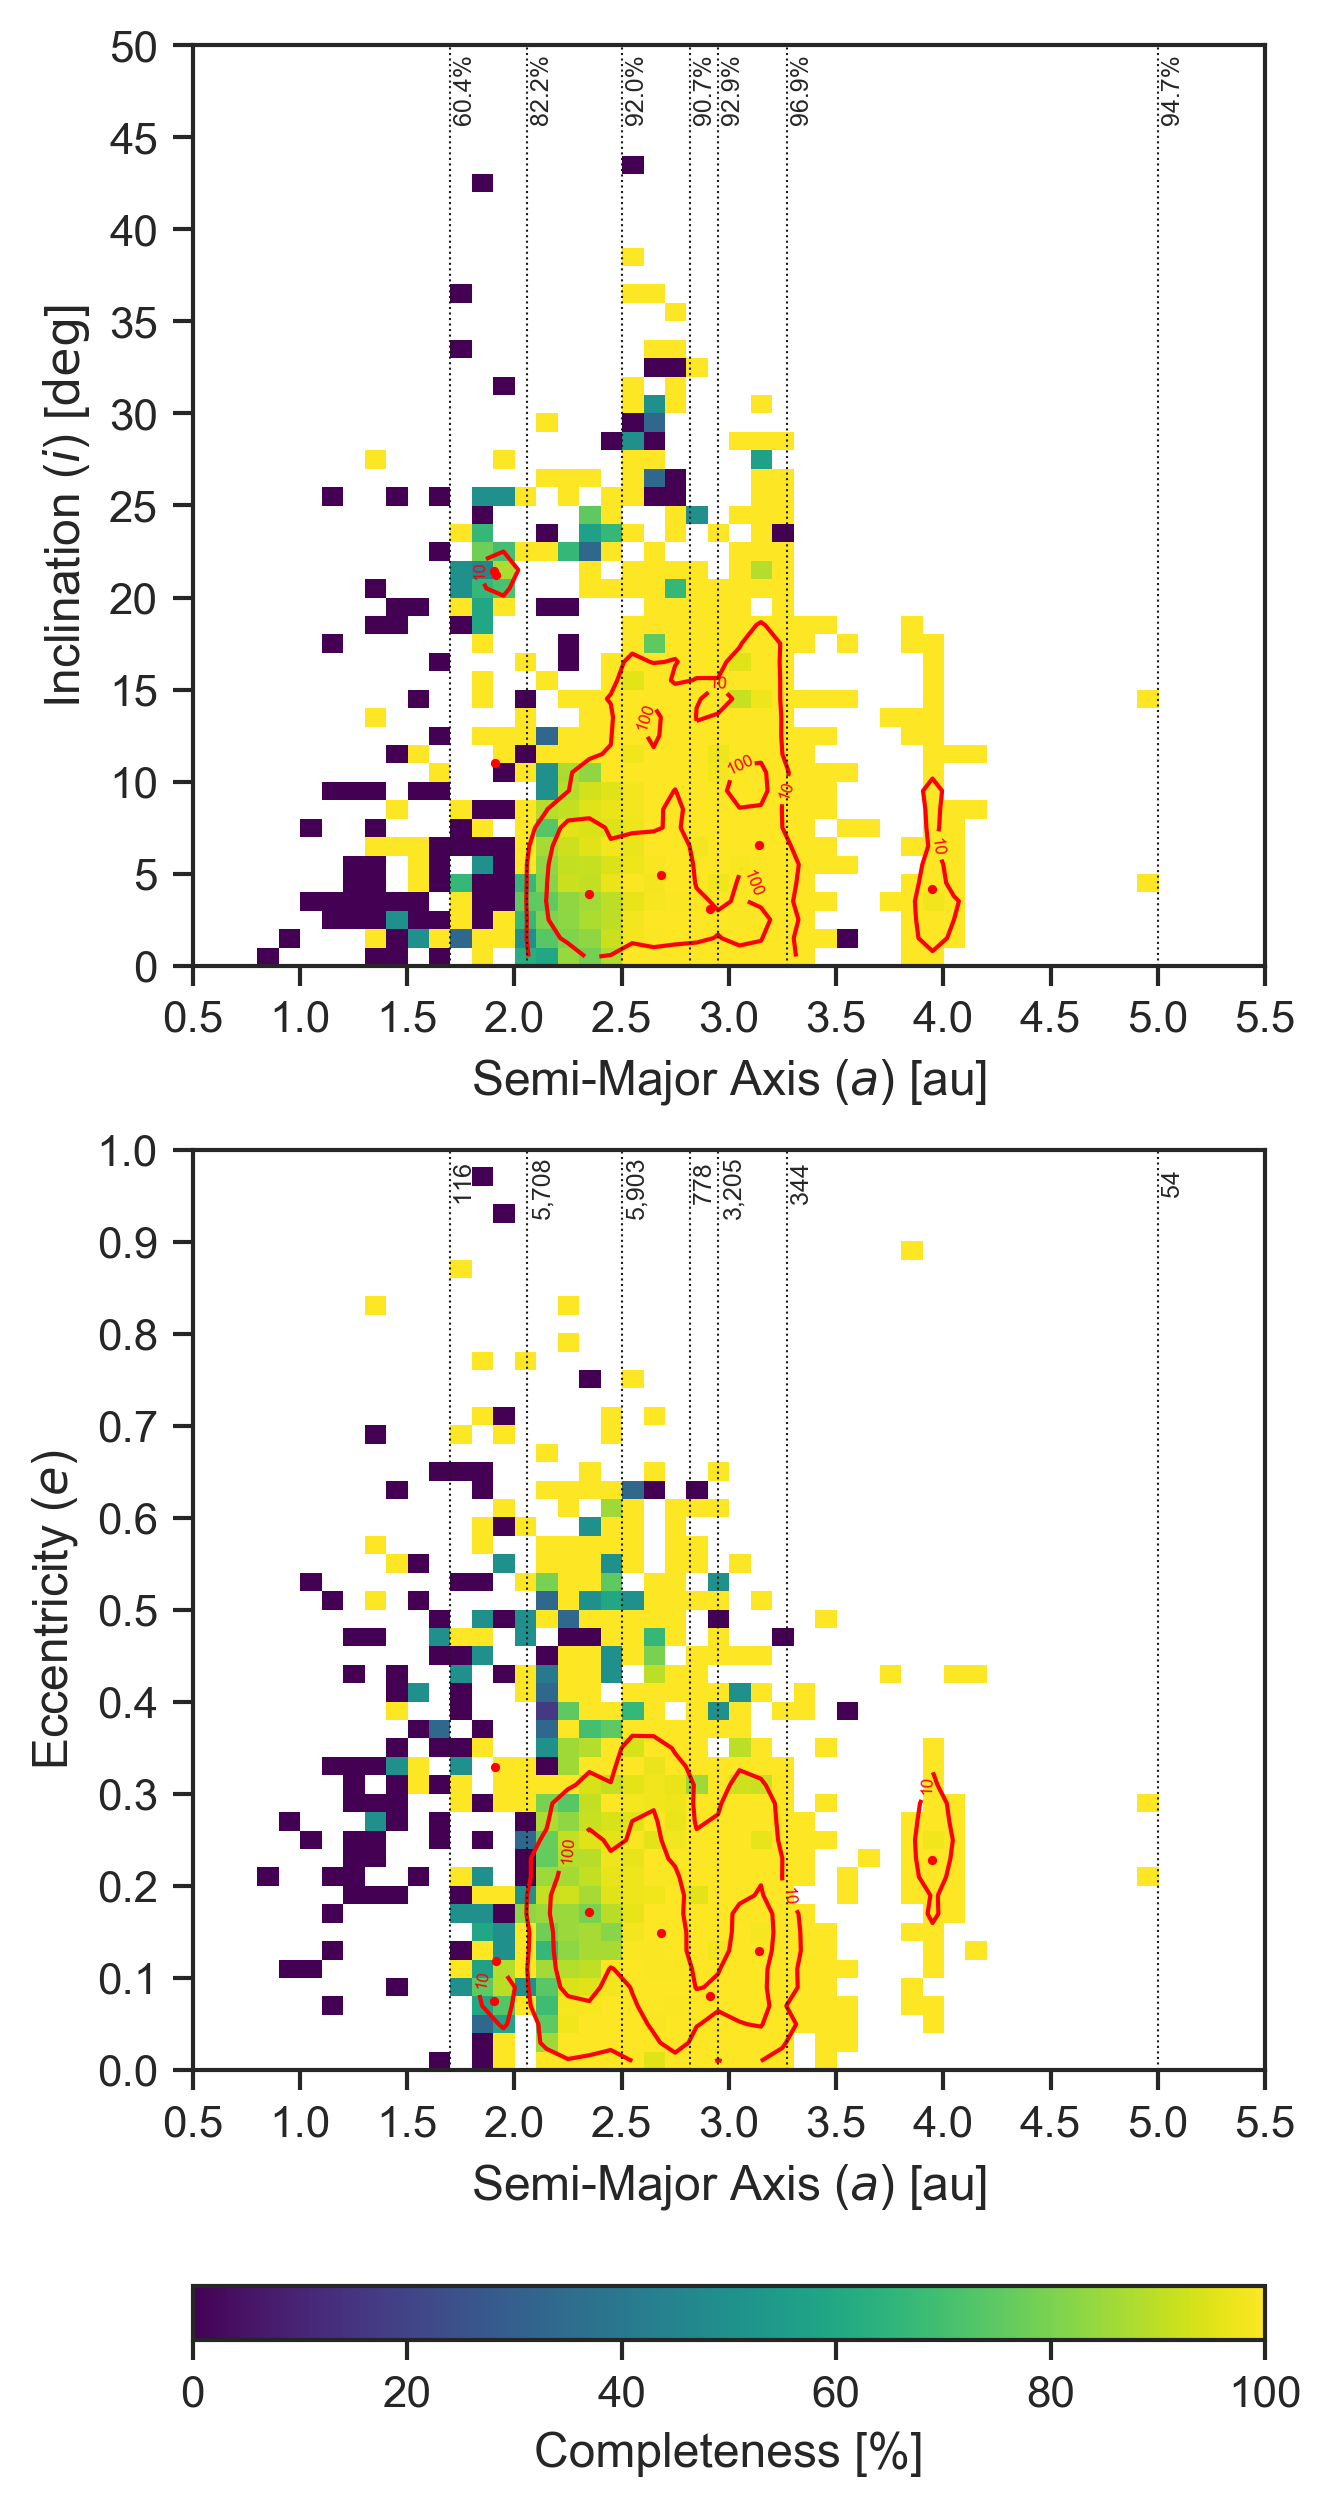

In [17]:
fig, ax = plotCompleteness(allObjects_survey, 
                 known_orbits, 
                 testOrbits=known_orbits[known_orbits["designation"].isin(test_orbits)])
ax[0].vlines([1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0], 0, 50, lw=0.5, linestyle=":")
ax[1].vlines([1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0], 0, 50, lw=0.5, linestyle=":")
ax[0].text(1.72, 45.5, " 60.4%", fontsize=6, rotation='vertical')
ax[0].text(2.08, 45.5, " 82.2%", fontsize=6, rotation='vertical')
ax[0].text(2.52, 45.5, " 92.0%", fontsize=6, rotation='vertical')
ax[0].text(2.84, 45.5, " 90.7%", fontsize=6, rotation='vertical')
ax[0].text(2.97, 45.5, " 92.9%", fontsize=6, rotation='vertical')
ax[0].text(3.29, 45.5, " 96.9%", fontsize=6, rotation='vertical')
ax[0].text(5.02, 45.5, " 94.7%", fontsize=6, rotation='vertical')

ax[1].text(1.72, 0.93, "  116", fontsize=6, rotation='vertical')
ax[1].text(2.08, 0.93, "5,708", fontsize=6, rotation='vertical')
ax[1].text(2.52, 0.93, "5,903", fontsize=6, rotation='vertical')
ax[1].text(2.84, 0.93, "  778", fontsize=6, rotation='vertical')
ax[1].text(2.97, 0.93, "3,205", fontsize=6, rotation='vertical')
ax[1].text(3.29, 0.93, "  344", fontsize=6, rotation='vertical')
ax[1].text(5.02, 0.93, "   54", fontsize=6, rotation='vertical')


if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "simulations_a_ie_completeness_iod.{}".format(FORMAT)),
            bbox_inches='tight')

### ZTF 

In [18]:
columnMapping = {        
        
        # Observation ID
        "obs_id" : "obs_id",
        
        # Exposure time
        "exp_mjd" : "exp_mjd",
        
        # Visit ID
        "visit_id" : "visit_id",
        
        # Field ID
        "field_id" : "field",
        
        # Field RA in degrees
        "field_RA_deg" : "fieldRA_deg",
        
        # Field Dec in degrees
        "field_Dec_deg" : "fieldDec_deg",
        
        # Night number
        "night": "nid",
        
        # RA in degrees
        "RA_deg" : "ra",
        
        # Dec in degrees
        "Dec_deg" : "decl",
        
        # Observer's x coordinate in AU
        "obs_x_au" : "HEclObsy_X_au",
        
        # Observer's y coordinate in AU
        "obs_y_au" : "HEclObsy_Y_au",
        
        # Observer's z coordinate in AU
        "obs_z_au" : "HEclObsy_Z_au",
        
        # Magnitude (UNUSED)
        "mag" : "magpsf",
        
        ### Truth Parameters
        
        # Object name
        "name" : "designation",
        
        # Observer-object distance in AU
        "Delta_au" : "Delta_au",
        
        # Sun-object distance in AU (heliocentric distance)
        "r_au" : "r_au",
        
        # Object's x coordinate in AU
        "obj_x_au" : "HEclObj_X_au",
        
        # Object's y coordinate in AU
        "obj_y_au" : "HEclObj_Y_au",
        
        # Object's z coordinate in AU
        "obj_z_au" : "HEclObj_Z_au",
        
        # Object's x velocity in AU per day
        "obj_dx/dt_au_p_day" : "HEclObj_dX/dt_au_p_day",
        
        # Object's y velocity in AU per day
        "obj_dy/dt_au_p_day" : "HEclObj_dY/dt_au_p_day",
        
        # Object's z velocity in AU per day
        "obj_dz/dt_au_p_day" : "HEclObj_dZ/dt_au_p_day",
        
        # Semi-major axis
        "a_au" : "a_au",
        
        # Inclination
        "i_deg" : "i_deg",
        
        # Eccentricity
        "e" : "e",
    }

In [19]:
RUN_DIR = "/Users/moeyensj/Google Drive/Astronomy/Data/thor/results/ztf/run_16/"
IOD_DIR = os.path.join(RUN_DIR, "iod_orbits")
DATA_DIR =  "/Users/moeyensj/Google Drive/Astronomy/Data/thor/data/ztf/ztf/"

In [20]:
allObjects_survey = pd.read_csv(os.path.join(RUN_DIR, "allObjects_survey.txt"), sep=" ", index_col=False)
test_orbits_survey = pd.read_csv(os.path.join(RUN_DIR, "orbits.txt"), sep=" ", index_col=False)
orbits = thor.readORBFile(os.path.join(DATA_DIR, "MPCORB_20181106_ZTF_keplerian.orb"), elementType="keplerian")

In [21]:
findable = allObjects_survey[allObjects_survey["findable"] == 1]["designation"].values
found = allObjects_survey[allObjects_survey["found"] == 1]["designation"].values
missed = allObjects_survey[(allObjects_survey["found"] == 0) & (allObjects_survey["findable"] == 1) ]["designation"].values
test_orbits = test_orbits_survey["designation"].values

In [22]:
# Loop through the IOD orbits directory, read orbit file, crossmatch orbit with the clusterMembers DataFrame to calculate
# arc length 
DO_PROCESSING = False
if DO_PROCESSING:
    iod_orbits = []
    cluster_members = []
    for iod_file in os.listdir(IOD_DIR):
        orbits_df = pd.read_csv(os.path.join(IOD_DIR, iod_file),
                         sep=" ", 
                         index_col=False, 
                         low_memory=False,
                         header=0,
                         names=["orbit_id", "cluster_id", "epoch_mjd",
                                "obj_x", "obj_y", "obj_z", 
                                "obj_vx", "obj_vy", "obj_vz", 
                                "rchi2",  "linked_object",
                                "pure", "partial", "false"],
                         dtype={"linked_object" : str})


        orbit_id = iod_file.split("_")[2].split(".")[0]
        orbit_dir = os.path.join(RUN_DIR, "orbit_{}".format(orbit_id))

        allClusters = pd.read_csv(os.path.join(orbit_dir, "allClusters.txt"), sep=" ", index_col=False, low_memory=False, dtype={"linked_object" : str})
        clusterMembers = pd.read_csv(os.path.join(orbit_dir, "clusterMembers.txt"), sep=" ", index_col=False, low_memory=False)
        projected_obs = pd.read_csv(os.path.join(orbit_dir, "projected_obs.txt"), sep=" ", index_col=False, low_memory=False)

        orbits_df = orbits_df.merge(allClusters[["cluster_id", "num_obs"]], on="cluster_id")
        orbits_df["chi2"] = orbits_df["rchi2"] * (2 * orbits_df["num_obs"] - 6)

        merged = clusterMembers.merge(projected_obs[[columnMapping["obs_id"], "exp_mjd"]], on=columnMapping["obs_id"])
        merged.sort_values(by=["cluster_id", "exp_mjd"], inplace=True)
        merged.reset_index(inplace=True, drop=True)
        merged = pd.DataFrame(merged.groupby(by="cluster_id").apply(lambda x: x.exp_mjd.max() - x.exp_mjd.min()), columns=["arc"])
        merged.reset_index(inplace=True)
        
        clusterMembers = clusterMembers[clusterMembers["cluster_id"].isin(orbits_df["cluster_id"].unique())] 
        clusterMembers["orbit_id"] = [orbits_df["orbit_id"].values[0] for i in range(len(clusterMembers))]
        clusterMembers = clusterMembers[["orbit_id", "cluster_id", columnMapping["obs_id"]]]

        orbits_df = orbits_df.merge(merged[["cluster_id", "arc"]], on="cluster_id")
        orbits_df = orbits_df[[
            'orbit_id', 'cluster_id', 'epoch_mjd',
            'obj_x', 'obj_y', 'obj_z',
            'obj_vx', 'obj_vy', 'obj_vz',  
            'pure', 'partial', 'false', 
            'linked_object', 'num_obs', 'rchi2', 
            'chi2', 'arc'
        ]]
        
        cluster_members.append(clusterMembers)
        iod_orbits.append(orbits_df)

    iod_orbits = pd.concat(iod_orbits, sort=False)
    iod_orbits.sort_values(by=["orbit_id", "cluster_id"], inplace=True)
    iod_orbits.reset_index(inplace=True, drop=True)
    
    clusterMembers = pd.concat(cluster_members, sort=False)
    clusterMembers.sort_values(by=["orbit_id", "cluster_id"], inplace=True)
    clusterMembers.reset_index(inplace=True, drop=True)
    
    iod_orbits.to_csv(os.path.join(RUN_DIR, "processed_iod_orbits.txt"), sep=" ", index=False)
    clusterMembers.to_csv(os.path.join(RUN_DIR, "processed_orbit_members.txt"), sep=" ", index=False)
    
else:
    iod_orbits = pd.read_csv(os.path.join(RUN_DIR, "processed_iod_orbits.txt"), sep=" ", index_col=False, low_memory=False, dtype={"linked_object" : str})
    clusterMembers = pd.read_csv(os.path.join(RUN_DIR, "processed_orbit_members.txt"), sep=" ", index_col=False, low_memory=False)

observations = pd.read_csv("/Users/moeyensj/Google Drive/Astronomy/Data/thor/data/ztf/ztf/observations_nid_610_624.txt", sep=" ", index_col=False, low_memory=False)

In [23]:
known, known_pure, known_partial, unknown = printIODResults(iod_orbits, allObjects_survey, chi2_cut=500, unknownIds=["-1", -1, np.NaN], falsePositiveIds=[])

Number of known objects recovered in clusters: 97.38%
Total number of known objects findable: 21401
Total number of known objects found in clusters: 20840

Total number of orbits: 1475580
Number of orbits chi-squared <= 500: 89304
	Number of orbits resulting from known pure clusters: 71523 (80.09%)
	Number of unique known objects in these orbits: 20457 (95.59%)
	Number of orbits resulting from known partial clusters: 4038 (4.52%)
	Number of unique known objects in these orbits: 271 (1.27%)
	Number of orbits resulting from unknown clusters: 13743 (15.39%)
Percent of known objects recovered in high quality orbits: 20460 95.60%


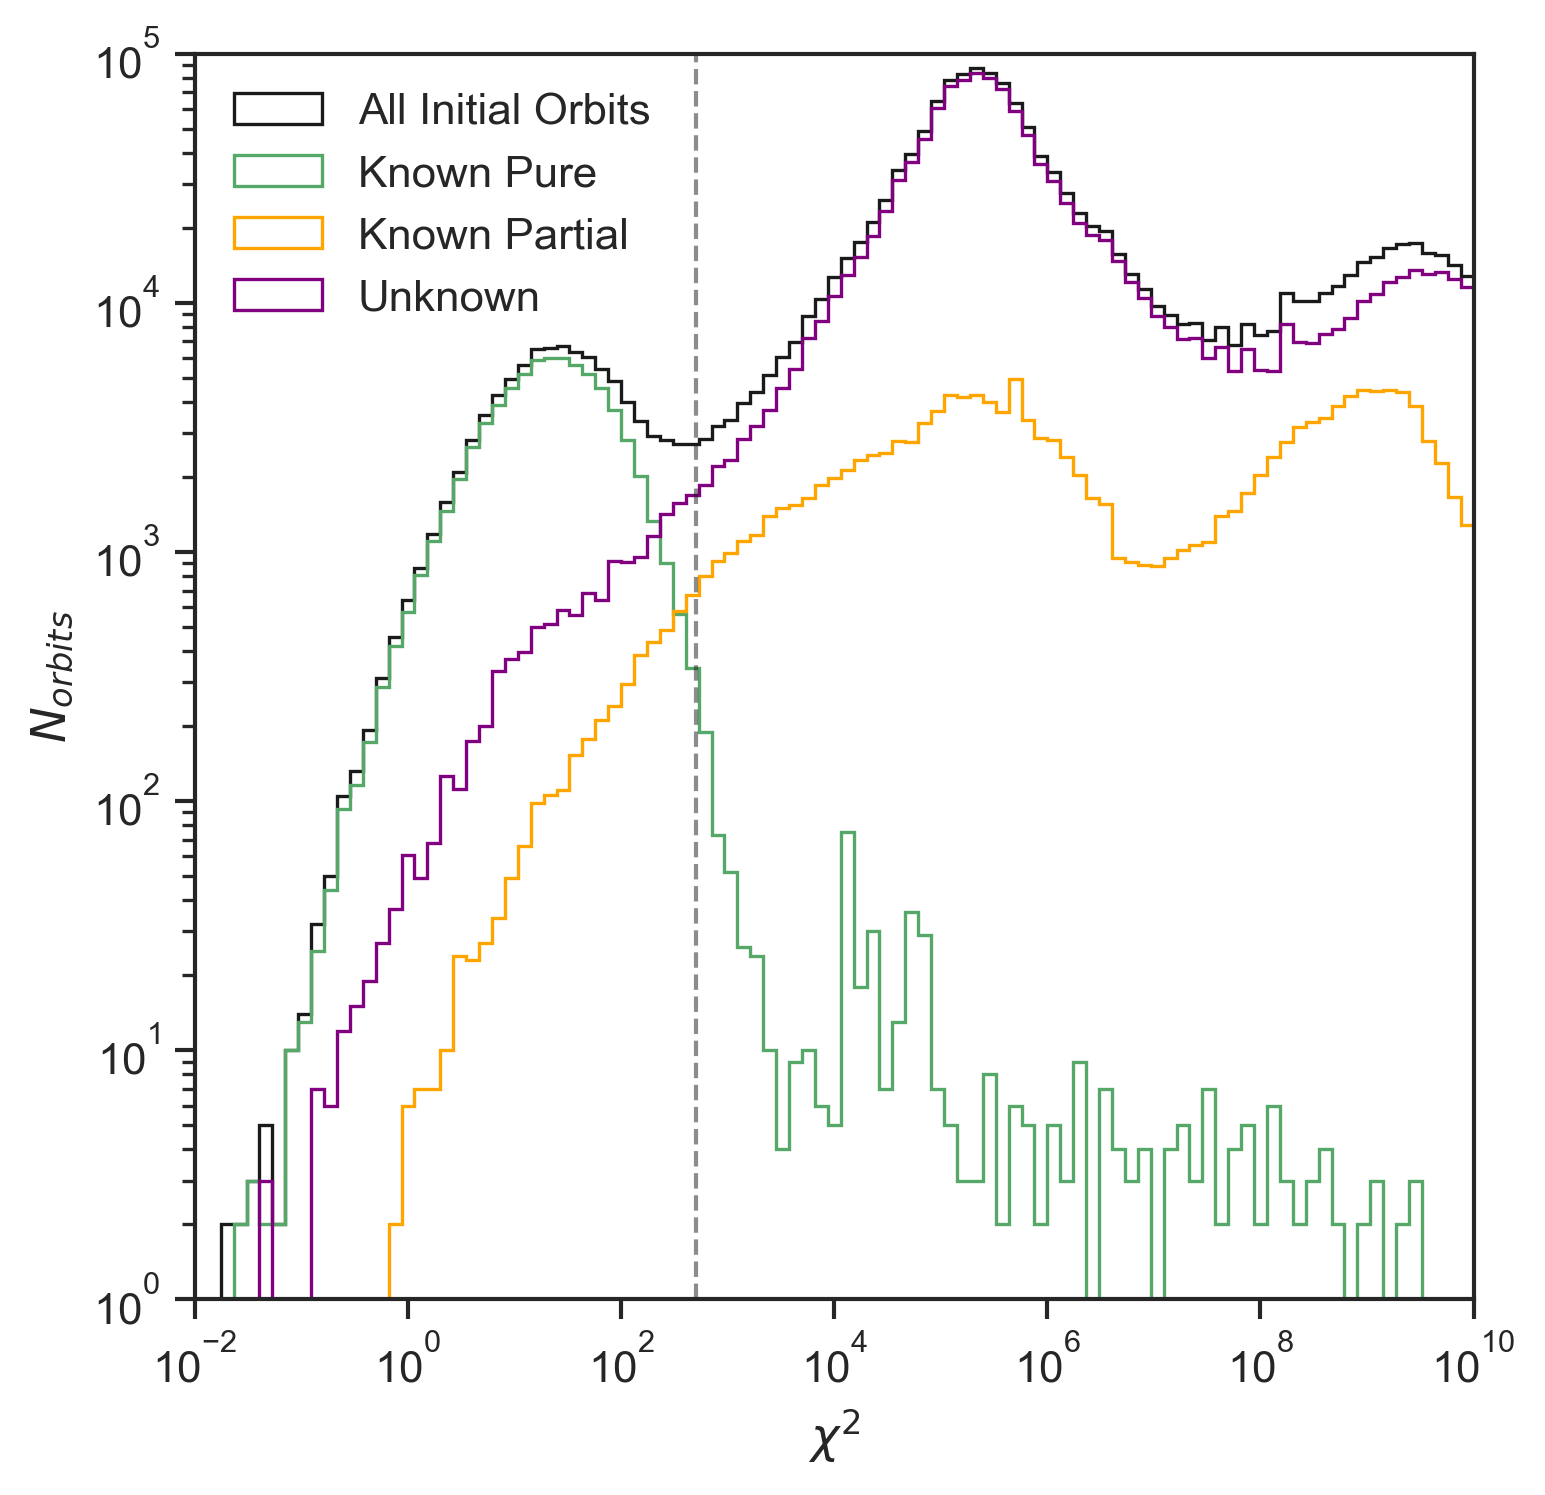

In [24]:
log_range = (-2, 10)
bins = 100

fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5.5, 5.5))
stats = ax.hist(iod_orbits["chi2"].values, 
                   bins=np.logspace(*log_range, bins),
                   density=False, 
                   histtype="step", 
                   label="All Initial Orbits",
                   color="k")
stats_pu = ax.hist(iod_orbits[known_pure]["chi2"].values, 
                   bins=np.logspace(*log_range, bins),
                   density=False, 
                   histtype="step", 
                   label="Known Pure",
                   color="g")
stats_pa = ax.hist(iod_orbits[known_partial]["chi2"].values,
                   bins=np.logspace(*log_range, bins),  
                   density=False, 
                   histtype="step",
                   label="Known Partial",
                   color="orange")
stats_un = ax.hist(iod_orbits[unknown]["chi2"].values, 
                   bins=np.logspace(*log_range, bins), 
                   density=False, 
                   histtype="step", 
                   label="Unknown",
                   color="purple")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.set_xlim(10**log_range[0], 10**log_range[1])
ax.set_ylim(1, 10**5)
ax.vlines([500], 1, 10**5, lw=1, ls="--", alpha=0.5)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$N_{orbits}$")
ax.set_xlabel(r"$\chi^2$")

ax.legend(loc="upper left", frameon=False)

if SAVE_FIGS == True:
    fig.savefig(os.path.join(SAVE_DIR, "ztf_iod.{}".format(FORMAT)),
            bbox_inches='tight')

In [25]:
found_iod = iod_orbits[(iod_orbits["chi2"] <= 500) & known]["linked_object"].unique()

In [26]:
known_orbits = orbits

sma_bins = [1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0, 50.0]

for a_min, a_max in zip(sma_bins[:-1], sma_bins[1:]):
    found_in_bin = len(known_orbits[(known_orbits["a_au"] >= a_min) & (known_orbits["a_au"] < a_max) & known_orbits["designation"].isin(found_iod)]) 
    findable_in_bin = len(known_orbits[(known_orbits["a_au"] >= a_min) & (known_orbits["a_au"] < a_max) & known_orbits["designation"].isin(findable)])
    print("Completeness between {} and {} AU: {:.2f} %, {}".format(a_min, a_max, found_in_bin / findable_in_bin * 100.0, found_in_bin))

Completeness between 1.7 and 2.06 AU: 91.30 %, 525
Completeness between 2.06 and 2.5 AU: 93.96 %, 6111
Completeness between 2.5 and 2.82 AU: 95.81 %, 7503
Completeness between 2.82 and 2.95 AU: 97.13 %, 711
Completeness between 2.95 and 3.27 AU: 97.85 %, 5324
Completeness between 3.27 and 5.0 AU: 96.91 %, 188
Completeness between 5.0 and 50.0 AU: 97.53 %, 79


In [27]:
sma_bins = [0.0, 1.7, 2.5, 50.0]
for a_min, a_max in zip(sma_bins[:-1], sma_bins[1:]):
    found_in_bin = len(known_orbits[(known_orbits["a_au"] >= a_min) & (known_orbits["a_au"] < a_max) & known_orbits["designation"].isin(found_iod)]) 
    findable_in_bin = len(known_orbits[(known_orbits["a_au"] >= a_min) & (known_orbits["a_au"] < a_max) & known_orbits["designation"].isin(findable)])
    print("Completeness between {} and {} AU: {:.2f} %, {}".format(a_min, a_max, found_in_bin / findable_in_bin * 100.0, found_in_bin))

Completeness between 0.0 and 1.7 AU: 43.90 %, 18
Completeness between 1.7 and 2.5 AU: 93.74 %, 6636
Completeness between 2.5 and 50.0 AU: 96.68 %, 13805


In [28]:
sma_bins = [0.0, 1.7, 50.0]
for a_min, a_max in zip(sma_bins[:-1], sma_bins[1:]):
    found_in_bin = len(known_orbits[(known_orbits["a_au"] >= a_min) & (known_orbits["a_au"] < a_max) & known_orbits["designation"].isin(found_iod)]) 
    findable_in_bin = len(known_orbits[(known_orbits["a_au"] >= a_min) & (known_orbits["a_au"] < a_max) & known_orbits["designation"].isin(findable)])
    print("Completeness between {} and {} AU: {:.2f} %, {}".format(a_min, a_max, found_in_bin / findable_in_bin * 100.0, found_in_bin))

Completeness between 0.0 and 1.7 AU: 43.90 %, 18
Completeness between 1.7 and 50.0 AU: 95.71 %, 20441


/Users/moeyensj/software/anaconda3/envs/thor_py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning:

invalid value encountered in true_divide

/Users/moeyensj/software/anaconda3/envs/thor_py36/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning:

invalid value encountered in true_divide



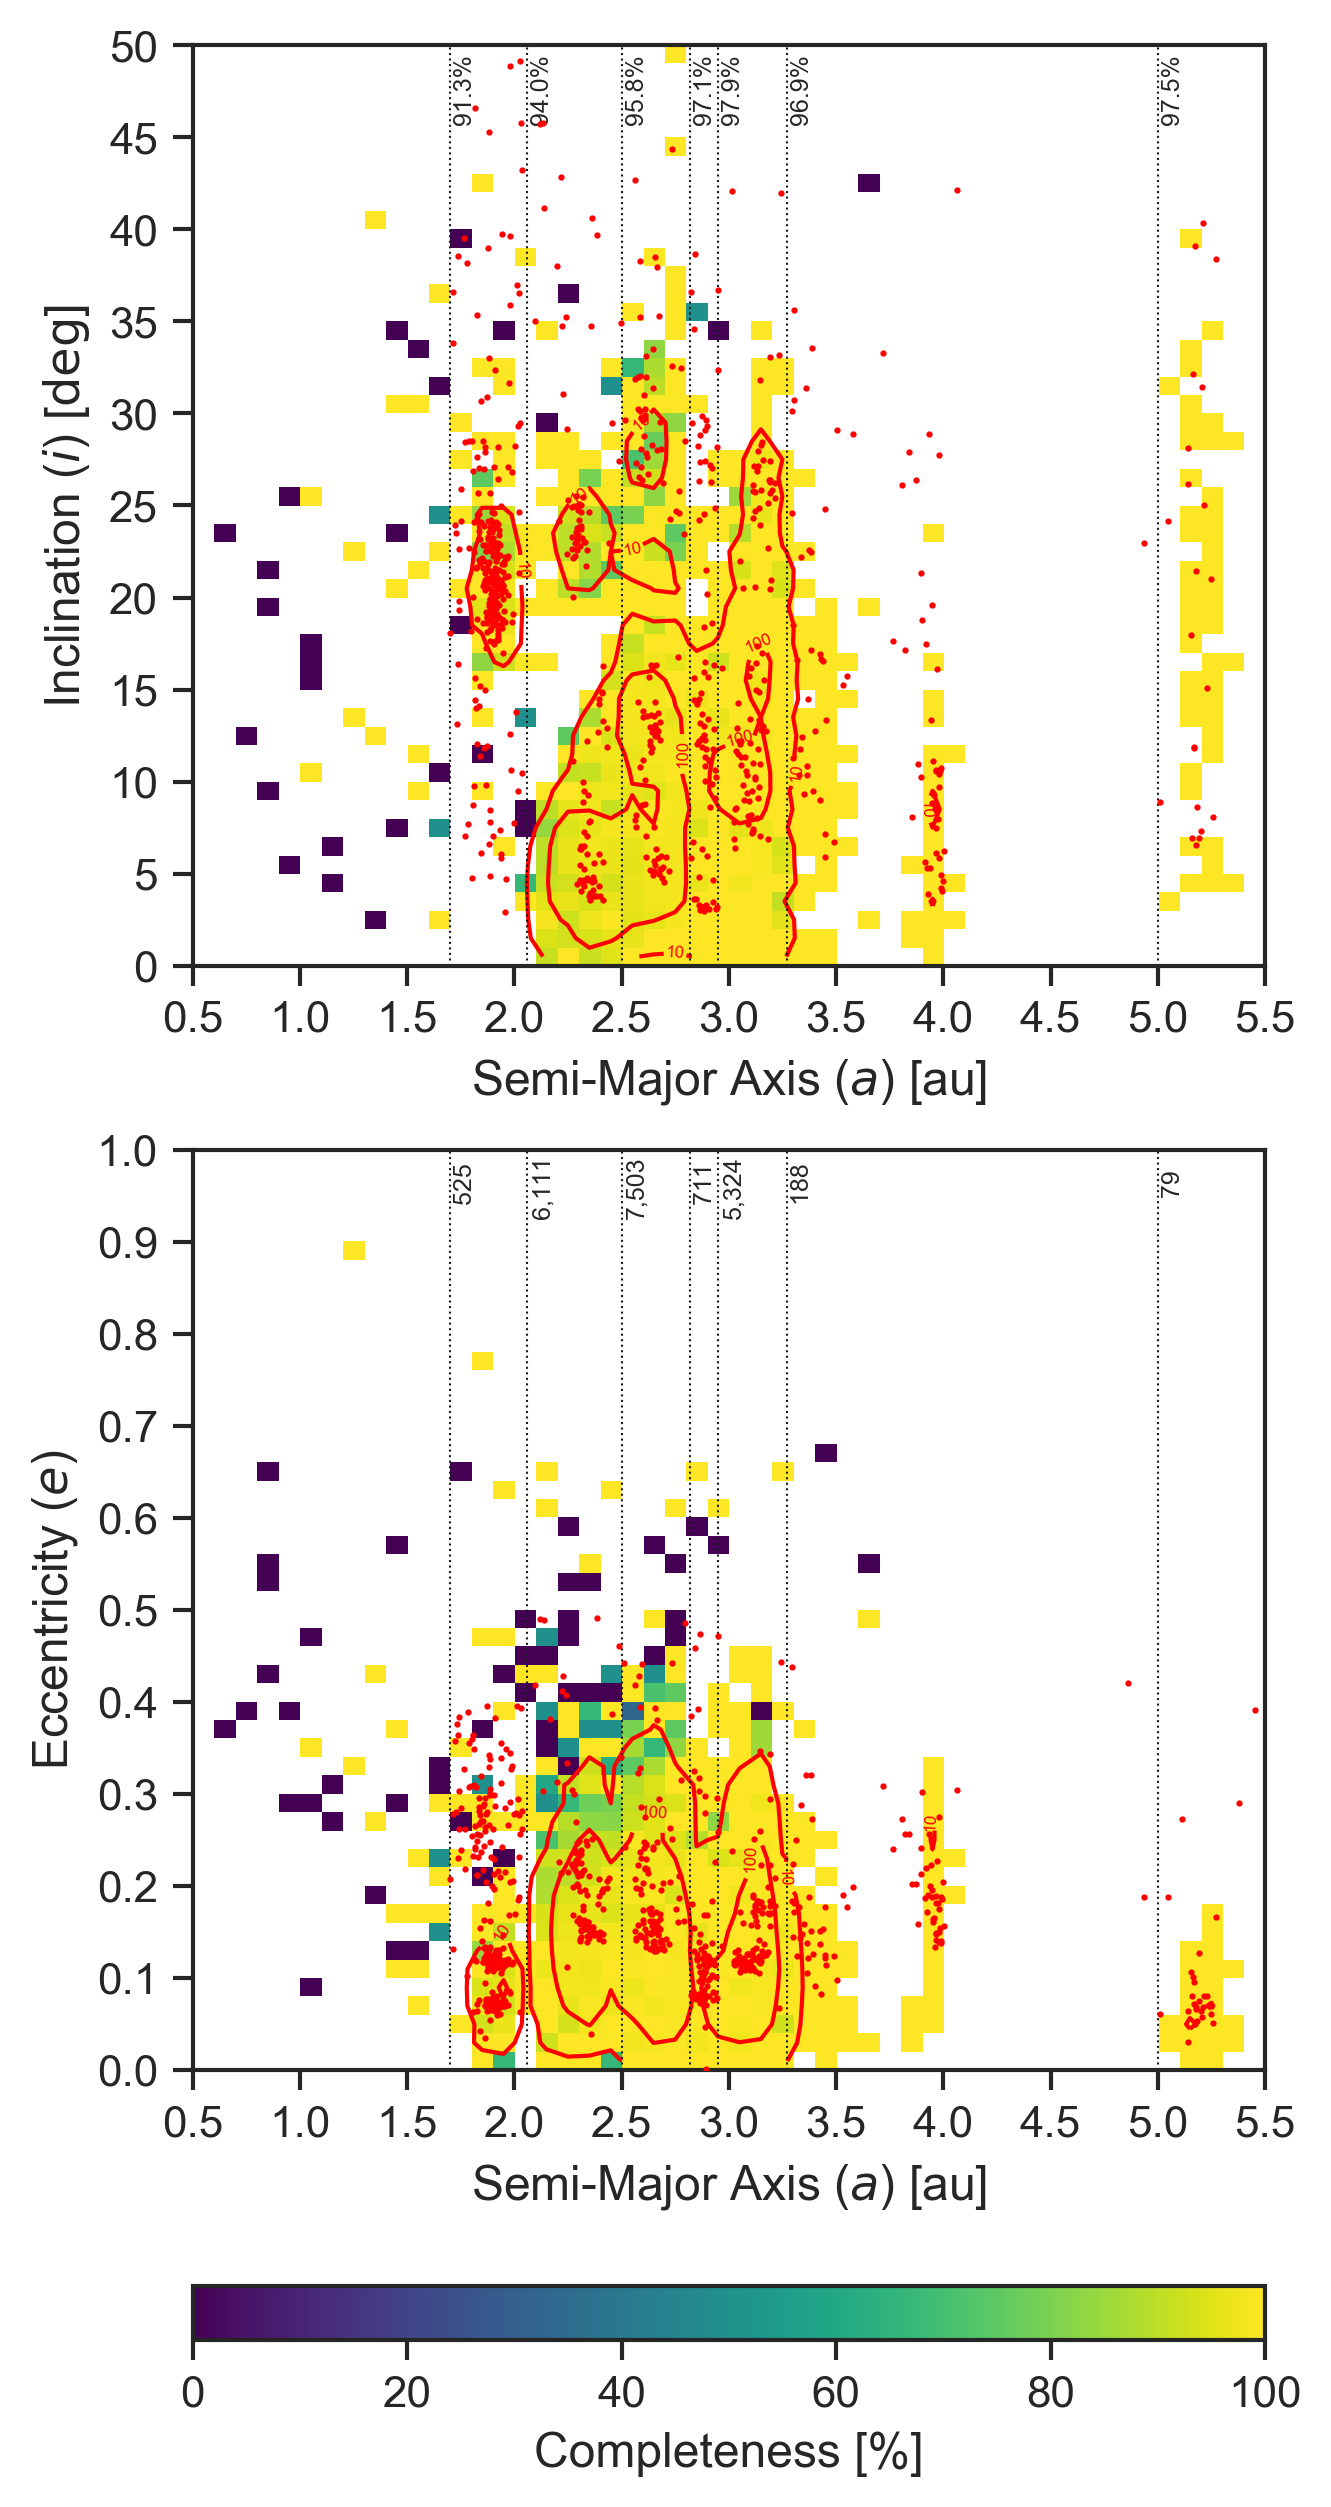

In [29]:
fig, ax = plotCompleteness(allObjects_survey, 
                 orbits, 
                 testOrbits=orbits[orbits["designation"].isin(test_orbits)],
                 testOrbitScatterKwargs={"s": 0.5, "c": "red"},
                 columnMapping=columnMapping)
ax[0].vlines([1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0], 0, 50, lw=0.5, linestyle=":")
ax[1].vlines([1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0], 0, 50, lw=0.5, linestyle=":")
ax[0].text(1.72, 45.5, " 91.3%", fontsize=6, rotation='vertical')
ax[0].text(2.08, 45.5, " 94.0%", fontsize=6, rotation='vertical')
ax[0].text(2.52, 45.5, " 95.8%", fontsize=6, rotation='vertical')
ax[0].text(2.84, 45.5, " 97.1%", fontsize=6, rotation='vertical')
ax[0].text(2.97, 45.5, " 97.9%", fontsize=6, rotation='vertical')
ax[0].text(3.29, 45.5, " 96.9%", fontsize=6, rotation='vertical')
ax[0].text(5.02, 45.5, " 97.5%", fontsize=6, rotation='vertical')

ax[1].text(1.72, 0.93, "  525", fontsize=6, rotation='vertical')
ax[1].text(2.08, 0.93, "6,111", fontsize=6, rotation='vertical')
ax[1].text(2.52, 0.93, "7,503", fontsize=6, rotation='vertical')
ax[1].text(2.84, 0.93, "  711", fontsize=6, rotation='vertical')
ax[1].text(2.97, 0.93, "5,324", fontsize=6, rotation='vertical')
ax[1].text(3.29, 0.93, "  188", fontsize=6, rotation='vertical')
ax[1].text(5.02, 0.93, "   79", fontsize=6, rotation='vertical')

if SAVE_FIGS == True:
    fig.savefig(os.path.join(SAVE_DIR, "ztf_a_ie_completeness_iod.{}".format(FORMAT)),
            bbox_inches='tight')

In [30]:
from astropy import units as u

def aveResidCal(chi2, num_obs):
    
    chi = np.sqrt(chi2)
    residual_total = chi * (1/36000)
    return (residual_total / (2 * num_obs)) * u.degree.to(u.mas)

In [31]:
aveResidCal(10, 5)

31.622776601683793

In [32]:
aveResidCal(1000, 5)

316.2277660168379

In [33]:
aveResidCal(100000, 5)

3162.277660168379

In [34]:
aveResidCal(1000000, 5)

9999.999999999998

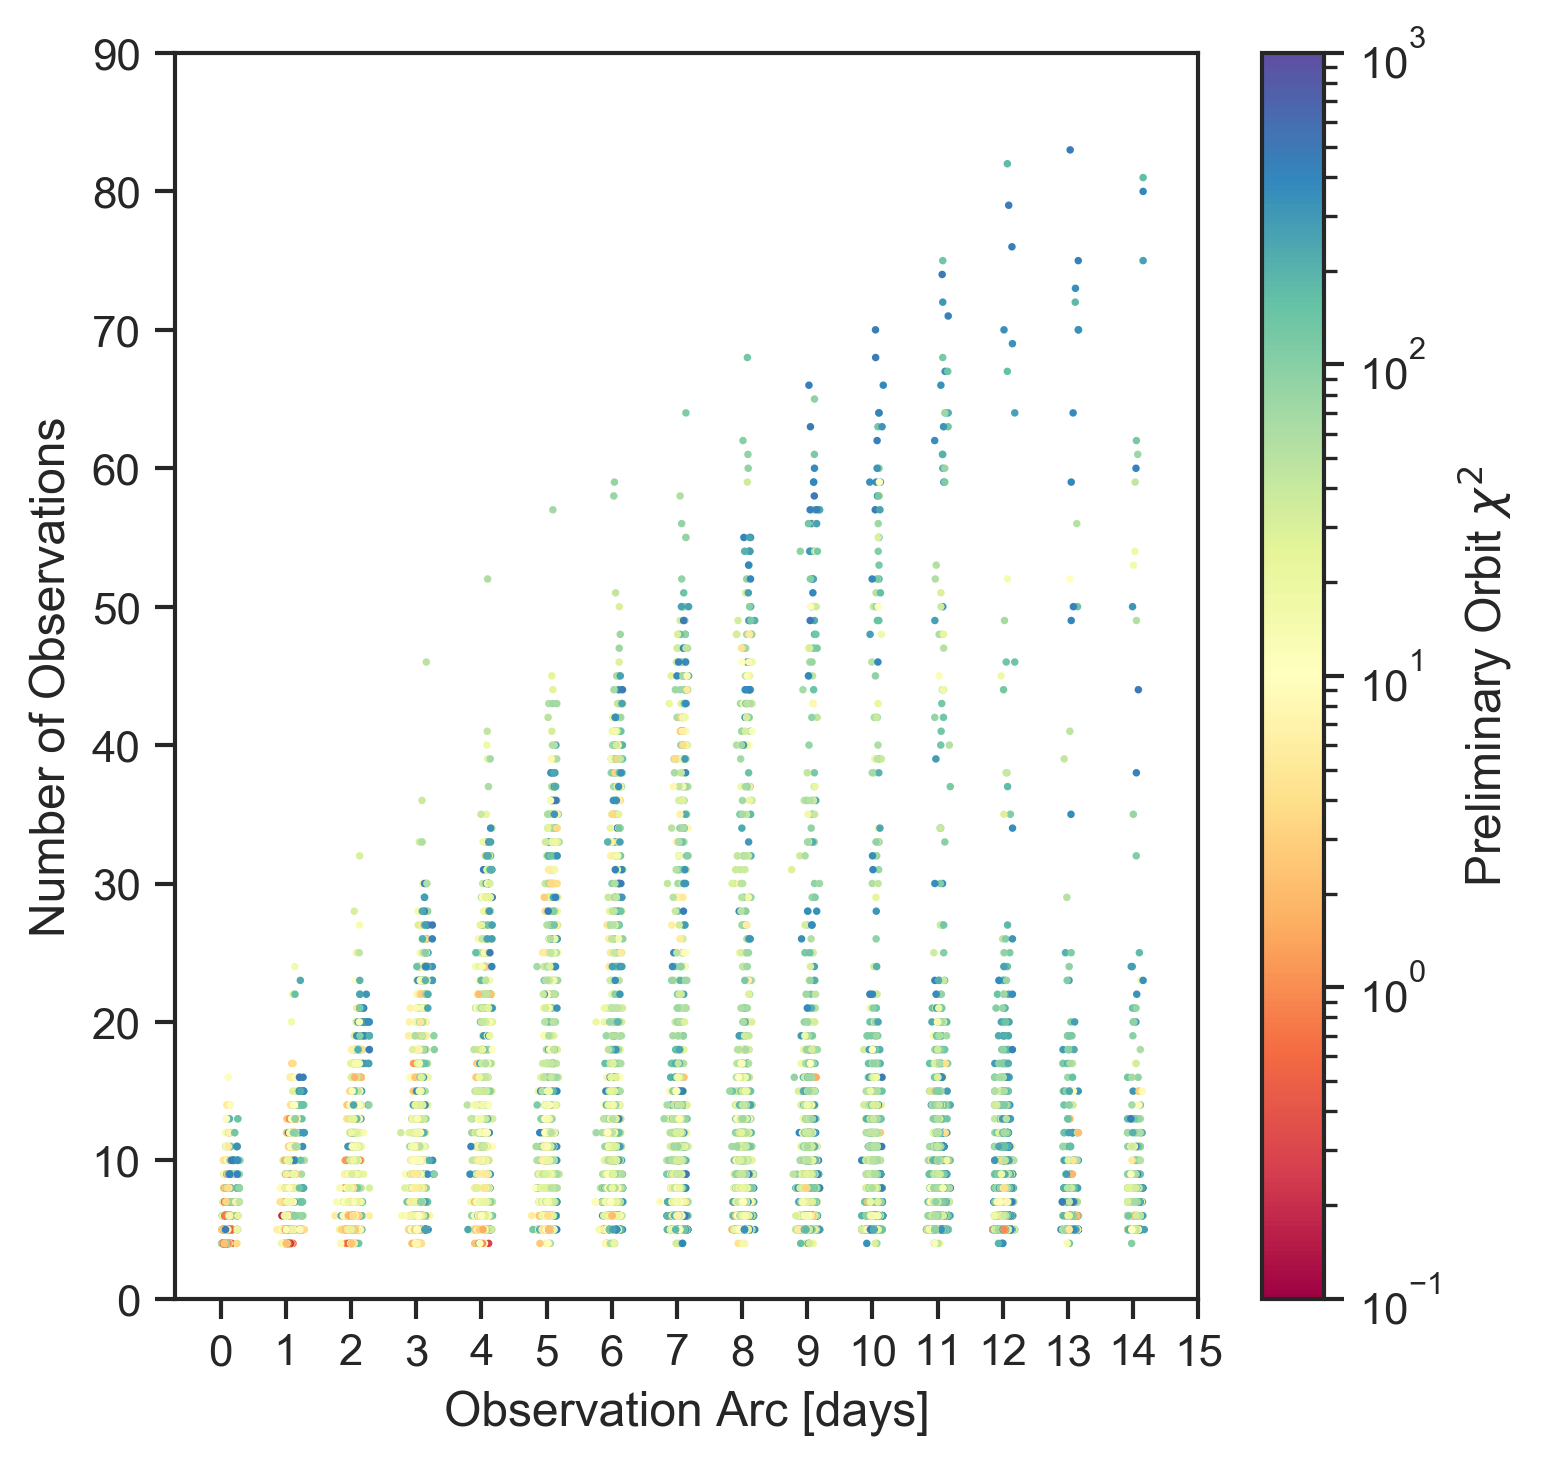

In [36]:
chi2 = 500
fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5.5, 5.5))
cm = ax.scatter(iod_orbits[iod_orbits["chi2"] <= chi2]["arc"].values,
           iod_orbits[iod_orbits["chi2"] <= chi2]["num_obs"].values,
           c=iod_orbits[iod_orbits["chi2"] <= chi2 ]["chi2"].values,
           s=1,
           alpha=1,
           norm=colors.LogNorm(vmin=0.1, vmax=10**3),
           cmap="Spectral")
cb = fig.colorbar(cm, label=r"Preliminary Orbit $\chi^2$")
#cb.set_ticks([])
ax.set_ylim(0,90)
ax.set_xticks(np.arange(0, 16))
ax.set_ylabel("Number of Observations")
ax.set_xlabel("Observation Arc [days]")
if SAVE_FIGS == True:
    fig.savefig(os.path.join(SAVE_DIR, "ztf_iod_arc.{}".format(FORMAT)),
            bbox_inches='tight')